In [1]:
#CHANGE THE PATH TO THE PATH AT YOUR PC!
path = "C:\\Users\\user\\Desktop\\TUe\\Topological\\Project\\Geolife Trajectories 1.3\\Data\\"
CITY_BORDERS = [40.19, 39.65, 115.98, 116.74]
crop_to_borders = True
#Optimal threshold for # of occurances per cell to be classified as a vetex - 600

import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from Graph import *

In [3]:
#df = pd.read_csv(".\\presets\\very_short.csv")
df = pd.read_csv(".\\presets\\0.csv")

tra0 = df["trajectory"].unique()[0]
dft0 = df[df["trajectory"] == tra0]

tra1 = df["trajectory"].unique()[1]
dft1 = df[df["trajectory"] == tra1]

dft01 = df[df["trajectory"].isin([tra0, tra1])]

df = dft0

#(possibly) cropping the data to the city borders:
if crop_to_borders:
    mask_north = df['latitude'] <= CITY_BORDERS[0]
    mask_south = df['latitude'] >= CITY_BORDERS[1]
    mask_east = df['longitude'] <= CITY_BORDERS[3]
    mask_west = df['longitude'] >= CITY_BORDERS[2]
    mask_all = mask_north & mask_south & mask_east & mask_west
    df = df[mask_all].reset_index(drop=True)
    
df

,latitude,longitude,altitude,date,change,trajectory,user,transportation
0,39.984683,116.318450,150,2008-10-23 10:53:10,NaN,0.20081,0,NaN
1,39.984686,116.318417,150,2008-10-23 10:53:15,0.000033,0.20081,0,NaN
2,39.984688,116.318385,150,2008-10-23 10:53:20,0.000032,0.20081,0,NaN
3,39.984655,116.318263,150,2008-10-23 10:53:25,0.000126,0.20081,0,NaN
4,39.984611,116.318026,150,2008-10-23 10:53:30,0.000241,0.20081,0,NaN
...,...,...,...,...,...,...,...,...
902,40.009172,116.321211,27,2008-10-23 19:10:52,0.000158,0.20081,0,NaN
903,40.009204,116.321130,26,2008-10-23 19:10:57,0.000087,0.20081,0,NaN
904,40.009243,116.321050,26,2008-10-23 19:11:02,0.000089,0.20081,0,NaN
905,40.009269,116.320978,26,2008-10-23 19:11:07,0.000077,0.20081,0,NaN


In [4]:
#Cell and Grid classes for dividing up the city into a grid

class Cell():
    '''Just your regular Square kind of a class'''
    def __init__(self, top: float, left: float, bottom: float, right: float):
        self.top = top
        self.left = left
        self.bottom = bottom
        self.right = right
        self.number_of_locations = 0
        self.is_vertex = False
        
    def __str__(self):
        return "Cell: top = " + str(round(self.top, 5)) + ", left = " + str(round(self.left, 5)) + \
    ", bottom = " + str(round(self.bottom, 5)) + ", right = " + str(round(self.right, 5))

    def belongs(self, latitude: float, longitude: float):
        '''checks if a point belongs to the cell - pass the point as (y, x)'''
        return (latitude > self.bottom and latitude <= self.top and longitude < self.right and longitude >= self.left)
    
    def vertexize(self, threshold = 600):
        '''makes the Cell become a vertex if has more locations that threshold'''
        
        if self.number_of_locations > threshold:
            self.is_vertex = True

    

class Grid():
    '''pretty much just a list of Cells that is available at self.cell_list'''
    
    def __init__(self, latitude_cells_nr: int, longitude_cells_nr: int, city_borders = CITY_BORDERS):
        self.latitude_cells_nr = latitude_cells_nr
        self.longitude_cells_nr = longitude_cells_nr
        self.city_borders = city_borders
        
        self.latitude_cell_length = round((city_borders[0] - city_borders[1])/latitude_cells_nr, 5)
        self.longitude_cell_length = round((city_borders[3] - city_borders[2])/longitude_cells_nr, 5)
        
        self.cell_list = []
        for i in range(latitude_cells_nr):
            for j in range(longitude_cells_nr):
                self.cell_list.append(Cell(top=city_borders[1] + self.latitude_cell_length*i,
                                     left=city_borders[2] + self.longitude_cell_length*j,
                                     bottom=city_borders[1] + self.latitude_cell_length*(i+1),
                                     right=city_borders[2] + self.longitude_cell_length*(j+1)))
                
    def __str__(self):
        return "Grid of side length (latitude) " + str(self.latitude_cell_length) + \
    " and (longitude) " + str(self.longitude_cell_length) + " and total number of cells: " + \
    str(self.latitude_cells_nr*self.longitude_cells_nr)

        
    def feed_list_of_points(self, points: list):
        '''point is a tuple (y, x) - DO NOT MESS THE Y AND X UP!
        increase the number_of_locations for each cell, if the point belongs there'''
        
        for point in points:
            for cell in self.cell_list:
                if cell.belongs(point[0], point[1]):
                    cell.number_of_locations += 1
                    break
                    
                    
    def feed_list_of_cell_numbers(self, cell_numbers: list):
        '''for each cell number in the list, update the corresponding cell details'''
        
        for number in cell_numbers:
            self.cell_list[int(number)].number_of_locations += 1
            
    
    def vertexize(self, threshold):
        '''runs vertexize on each sell of the grid'''
        
        for cell in self.cell_list:
            cell.vertexize(threshold)
            
    def get_list_of_vertices(self) -> list:
        '''returns the numbers of all cells that are vertices (is_vertex() == True)'''
        
        return [i for i in range(len(self.cell_list)) if self.cell_list[i].is_vertex]

In [5]:
#Grid creation example:
grid = Grid(30, 30) 
print(grid)
print(grid.cell_list[0].number_of_locations)

Grid of side length (latitude) 0.018 and (longitude) 0.02533 and total number of cells: 900
0


The following will check which cell in the grid does each row of the dataframe correspond to:

In [6]:
def latitude_to_row(latitude: float, latitude_cells_number: int, 
                    latitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given latitude in the row of a datafame, checks which row number in the grid the point belongs to'''
    
    for i in range(latitude_cells_number):
        if latitude < CITY_BORDERS[1] + i*latitude_cell_length: #we do not have to check the other containment!
            return i
    

def longitude_to_column(longitude: float, longitude_cells_number: int, 
                        longitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given longitude in the row of a datafame, checks which column number in the grid the point belongs to'''
    
    for i in range(longitude_cells_number):
        if longitude < CITY_BORDERS[2] + i*longitude_cell_length: #we do not have to check the other containment!
            return i
        

def row_column_to_cell_number(row_nr: int, column_nr: int, longitude_cells_nr: int):
    '''given the x and y in the grid, calculates the cell number'''
    
    return row_nr*longitude_cells_nr + column_nr
# lambda x,y,z: x*y+z

In [7]:
#This will perform some expensive computation. Around 7s on the 160k dataset

df['column_number'] = df['latitude'].apply(latitude_to_row, args=(grid.latitude_cells_nr, 
                                                                  grid.latitude_cell_length, CITY_BORDERS))

df['row_number'] = df['longitude'].apply(longitude_to_column, args=(grid.longitude_cells_nr, 
                                                                    grid.longitude_cell_length, CITY_BORDERS))

df['cell_number'] = df.apply(lambda x: row_column_to_cell_number(x['column_number'], x['row_number'],
                                                                 grid.longitude_cells_nr),axis = 1)


df = df.drop(['column_number', 'row_number'], axis=1)
df = df.dropna(subset=['cell_number'])
df = df.reset_index(drop=True)

And this is the resulting dataframe:

In [8]:
df

,latitude,longitude,altitude,date,change,trajectory,user,transportation,cell_number
0,39.984683,116.318450,150,2008-10-23 10:53:10,NaN,0.20081,0,NaN,584
1,39.984686,116.318417,150,2008-10-23 10:53:15,0.000033,0.20081,0,NaN,584
2,39.984688,116.318385,150,2008-10-23 10:53:20,0.000032,0.20081,0,NaN,584
3,39.984655,116.318263,150,2008-10-23 10:53:25,0.000126,0.20081,0,NaN,584
4,39.984611,116.318026,150,2008-10-23 10:53:30,0.000241,0.20081,0,NaN,584
...,...,...,...,...,...,...,...,...,...
902,40.009172,116.321211,27,2008-10-23 19:10:52,0.000158,0.20081,0,NaN,614
903,40.009204,116.321130,26,2008-10-23 19:10:57,0.000087,0.20081,0,NaN,614
904,40.009243,116.321050,26,2008-10-23 19:11:02,0.000089,0.20081,0,NaN,614
905,40.009269,116.320978,26,2008-10-23 19:11:07,0.000077,0.20081,0,NaN,614


Determining whether the cell is or is not a vetex - for all cells in the grid:

In [16]:
#How many locations do we need for a cell to be classified as a vertex? Enter the threshold:
THRESHOLD = 10 #for vertices
THRESHOLD_EDGES = 0

#This actually performs the large computation:
grid.feed_list_of_cell_numbers(list(df.cell_number))

#And this just switches some flags around:
grid.vertexize(THRESHOLD)

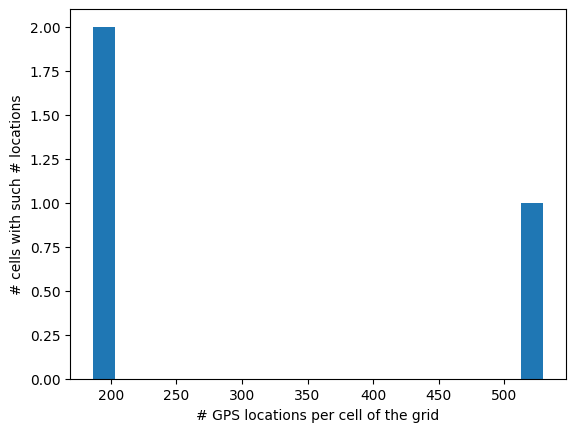

In [10]:
def plot_cell_containment(grid: Grid, threshold: int, bins = 20):
    ''''''
    wow = pd.Series([grid.cell_list[i].number_of_locations for i in range(grid.latitude_cells_nr*grid.longitude_cells_nr)])
    wow = pd.Series([wow[i] for i in range(len(wow)) if wow[i] > threshold])
    ax = wow.plot(kind='hist', bins=bins)
    ax.set_xlabel("# GPS locations per cell of the grid")
    ax.set_ylabel("# cells with such # locations")
    
plot_cell_containment(grid, threshold=THRESHOLD)

In [11]:
#By grouping per trajectory, we can find the unique vertices each trajectory has traversed!
df_grouped = df.groupby('trajectory')
print(grid.cell_list[12].is_vertex)

False


In [12]:
def find_subsequent_vertex_pairs(df_grouped) -> dict:
    '''if a trajectory has visited vertices: A, A, A, B, C, D, D; we will obtain
    (A, B), (B, C), (C, D) as the key of the resulting dictionary'''

    dic = {}
    
    #For each trajectory, get the list of unique cells it traversed:
    for element in df_grouped['cell_number'].unique():
        
        #Proceed if there was more than 1 cell that was traversed:
        if len(element)>1:
            
            #If the person went from a vertex to a vertex and not just ANY cell:
            if grid.cell_list[int(element[0])].is_vertex and grid.cell_list[int(element[1])].is_vertex:
                
                #Get all pairs of subsequent vertices
                list_of_pairs = [(int(element[i]), int(element[i+1])) for i in range(len(element)-1)]
                
                #Histogram code:
                for pair in list_of_pairs:
                    if pair not in dic:
                        dic[pair] = 1
                    else:
                        dic[pair] += 1

    return dic

In [13]:
#{(213, 7): 5, ...} meaning there are 5 trajectories that went from cell 213 to cell 7 immediately
edges_dict = find_subsequent_vertex_pairs(df_grouped)
edges_dict

{(584, 583): 1, (583, 613): 1, (613, 614): 1}

In [17]:
#Same as above, but filtered by a threshold
edges = [key for key in edges_dict if edges_dict[key] > THRESHOLD_EDGES]
edges[:10]

[(584, 583), (583, 613), (613, 614)]

In [19]:
def rav_graph_to_sven_graph_2(grid, edges):
    ''''''
    
    #Create a Graph object:
    g = Graph()
    
    #Create all Vertex objects and add them to the Graph:
    vertex_ids = grid.get_list_of_vertices()
    for ID in vertex_ids:
        #Feel free to change the top-left into bottom-right or the middle coordinates!
        v = Vertex(latitude=grid.cell_list[ID].top, longitude=grid.cell_list[ID].left, altitude=100)
        v.id = ID
        g.add_vertices(v)
    
    #return g

    #Create all Edge objects - they will have the vertices added (and vertices will have edges added):
    for pair in edges:
        #v1 is the Vertex such that Vertex.ID = pair[0], same for v2
        try:
            v1, v2 = [v for v in g.vertices if v.id == pair[0]][0], [v for v in g.vertices if v.id == pair[1]][0]
        except:
            print("broken pair: ", pair)
        
        #Adding vertices to edges:
        e = Edge(vertices=set( (v1, v2) ) )
        
#         #Adding edges to vertices: #AT THIS POINT I ASSUME GRAPH GOT UPDATED BY THE EDGES TOO?
#         v1.add_edges(e)
#         v2.add_edges(e)
            
    return g

In [20]:
g = rav_graph_to_sven_graph_2(grid, edges)

broken pair:  (583, 613)
broken pair:  (613, 614)


In [23]:
IDs = [vertex.id for vertex in g.vertices]
IDs

[584, 614, 583]

reduced from 907 to 3 points


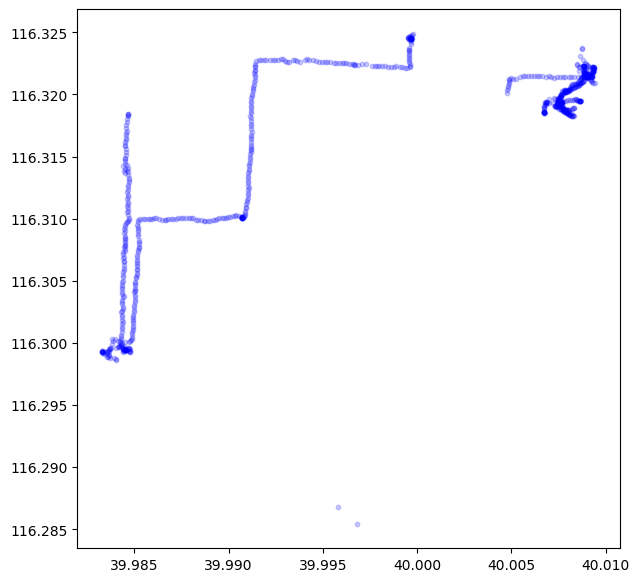

In [24]:
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(df.latitude, df.longitude, zorder=1, alpha= 0.2, c='b', s=10)

# for edge in g.edges:
#     lat1 = min(edge.vertices).latitude
#     long1 = min(edge.vertices).longitude
    
#     lat2 = max(edge.vertices).latitude
#     long2 = max(edge.vertices).longitude
    
#     plt.plot([lat1, lat2], [long1, long2], marker = 'o')

# star_vertices = [vertex for vertex in graph.vertices if len(vertex.edges) == 1]
# for vertex in star_vertices:
#     ax.plot(vertex.latitude, vertex.longitude, markersize=50)
    
ax = plt.gca()
#ax.set_xlim([40.0035, 40.0115])
#ax.set_ylim([116.3175, 116.3245])
print(f"reduced from {len(df)} to {len(g.vertices)} points")

In [26]:
g.remove_unconnected_vertices()
g.save('random_graph_t0')

In [25]:
# def rav_graph_to_sven_graph(grid: Grid, edges) -> Graph:
#     '''Using the edges list above and a list of vertices from the Grid structure,
#     create a Graph object with those vertices and edges to be used in the plotting'''
    
#     #This will store all the edges and vertices
#     g = Graph()

#     #For each cell in the grid:
#     for i in range(len(grid.cell_list)):

#         if grid.cell_list[i].is_vertex:

#             #Create a Sven's Vertex object for this vertex
#             #Feel free to change the top-left into bottom-right or the middle coordinates!
#             #Altitude is not contained in Cell class!
#             v = Vertex(latitude=grid.cell_list[i].top, longitude=grid.cell_list[i].left, altitude=100)

#             #See if there are any edges starting from that vertex (ending in that vertex is useless): 
#             for edge in edges:
#                 if edge[0]==i: #or edge[1]==i: #this OR actually makes each edge count twice, I think

#                     #Create a Sven's Edge object:
#                     e = Edge()

#                     #Add the edges one by one to the current Vertex:
#                     v.add_edges(e)

#             #After all the edges have been added, add the Vertex to the Graph:
#             g.add_vertices(v)
            
#     return g